<h3>Figure 1 plot currents, stokes drift, winds and temperature in the study region for december month of 2007, 2008, 2011, 2014 and 2021</h3>

In [1]:
from glob import glob
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean as cm
import numpy as np
np.set_printoptions(suppress=True)
import pandas as pd
import plotly as pt
import plotly.express as px

<h2>Currents and temperature data</h2>

In [2]:
cu_ds=xr.open_dataset('/storage/home/manra003/data/mean_uovo_December_Kemp.nc')
temp_ds=xr.open_dataset('/storage/home/manra003/data/mean_thetao_December_Kemp.nc')

cu_z0=cu_ds.isel(time=0).isel(depth=0)
temp_z0=temp_ds.isel(time=0).isel(depth=0)
np.min(temp_z0.thetao),np.max(temp_z0.thetao)

(<xarray.DataArray 'thetao' ()>
 array(-1.3362335, dtype=float32)
 Coordinates:
     time     datetime64[ns] 2012-12-16T02:24:00
     depth    float32 0.0,
 <xarray.DataArray 'thetao' ()>
 array(17.370096, dtype=float32)
 Coordinates:
     time     datetime64[ns] 2012-12-16T02:24:00
     depth    float32 0.0)

In [3]:
stations = pd.read_csv('/nethome/manra003/KempsRidley_turtle_strandings/data/Locations_NL.csv')
min_lon = -5
min_lat = 47
max_lon = 8 
max_lat = 57

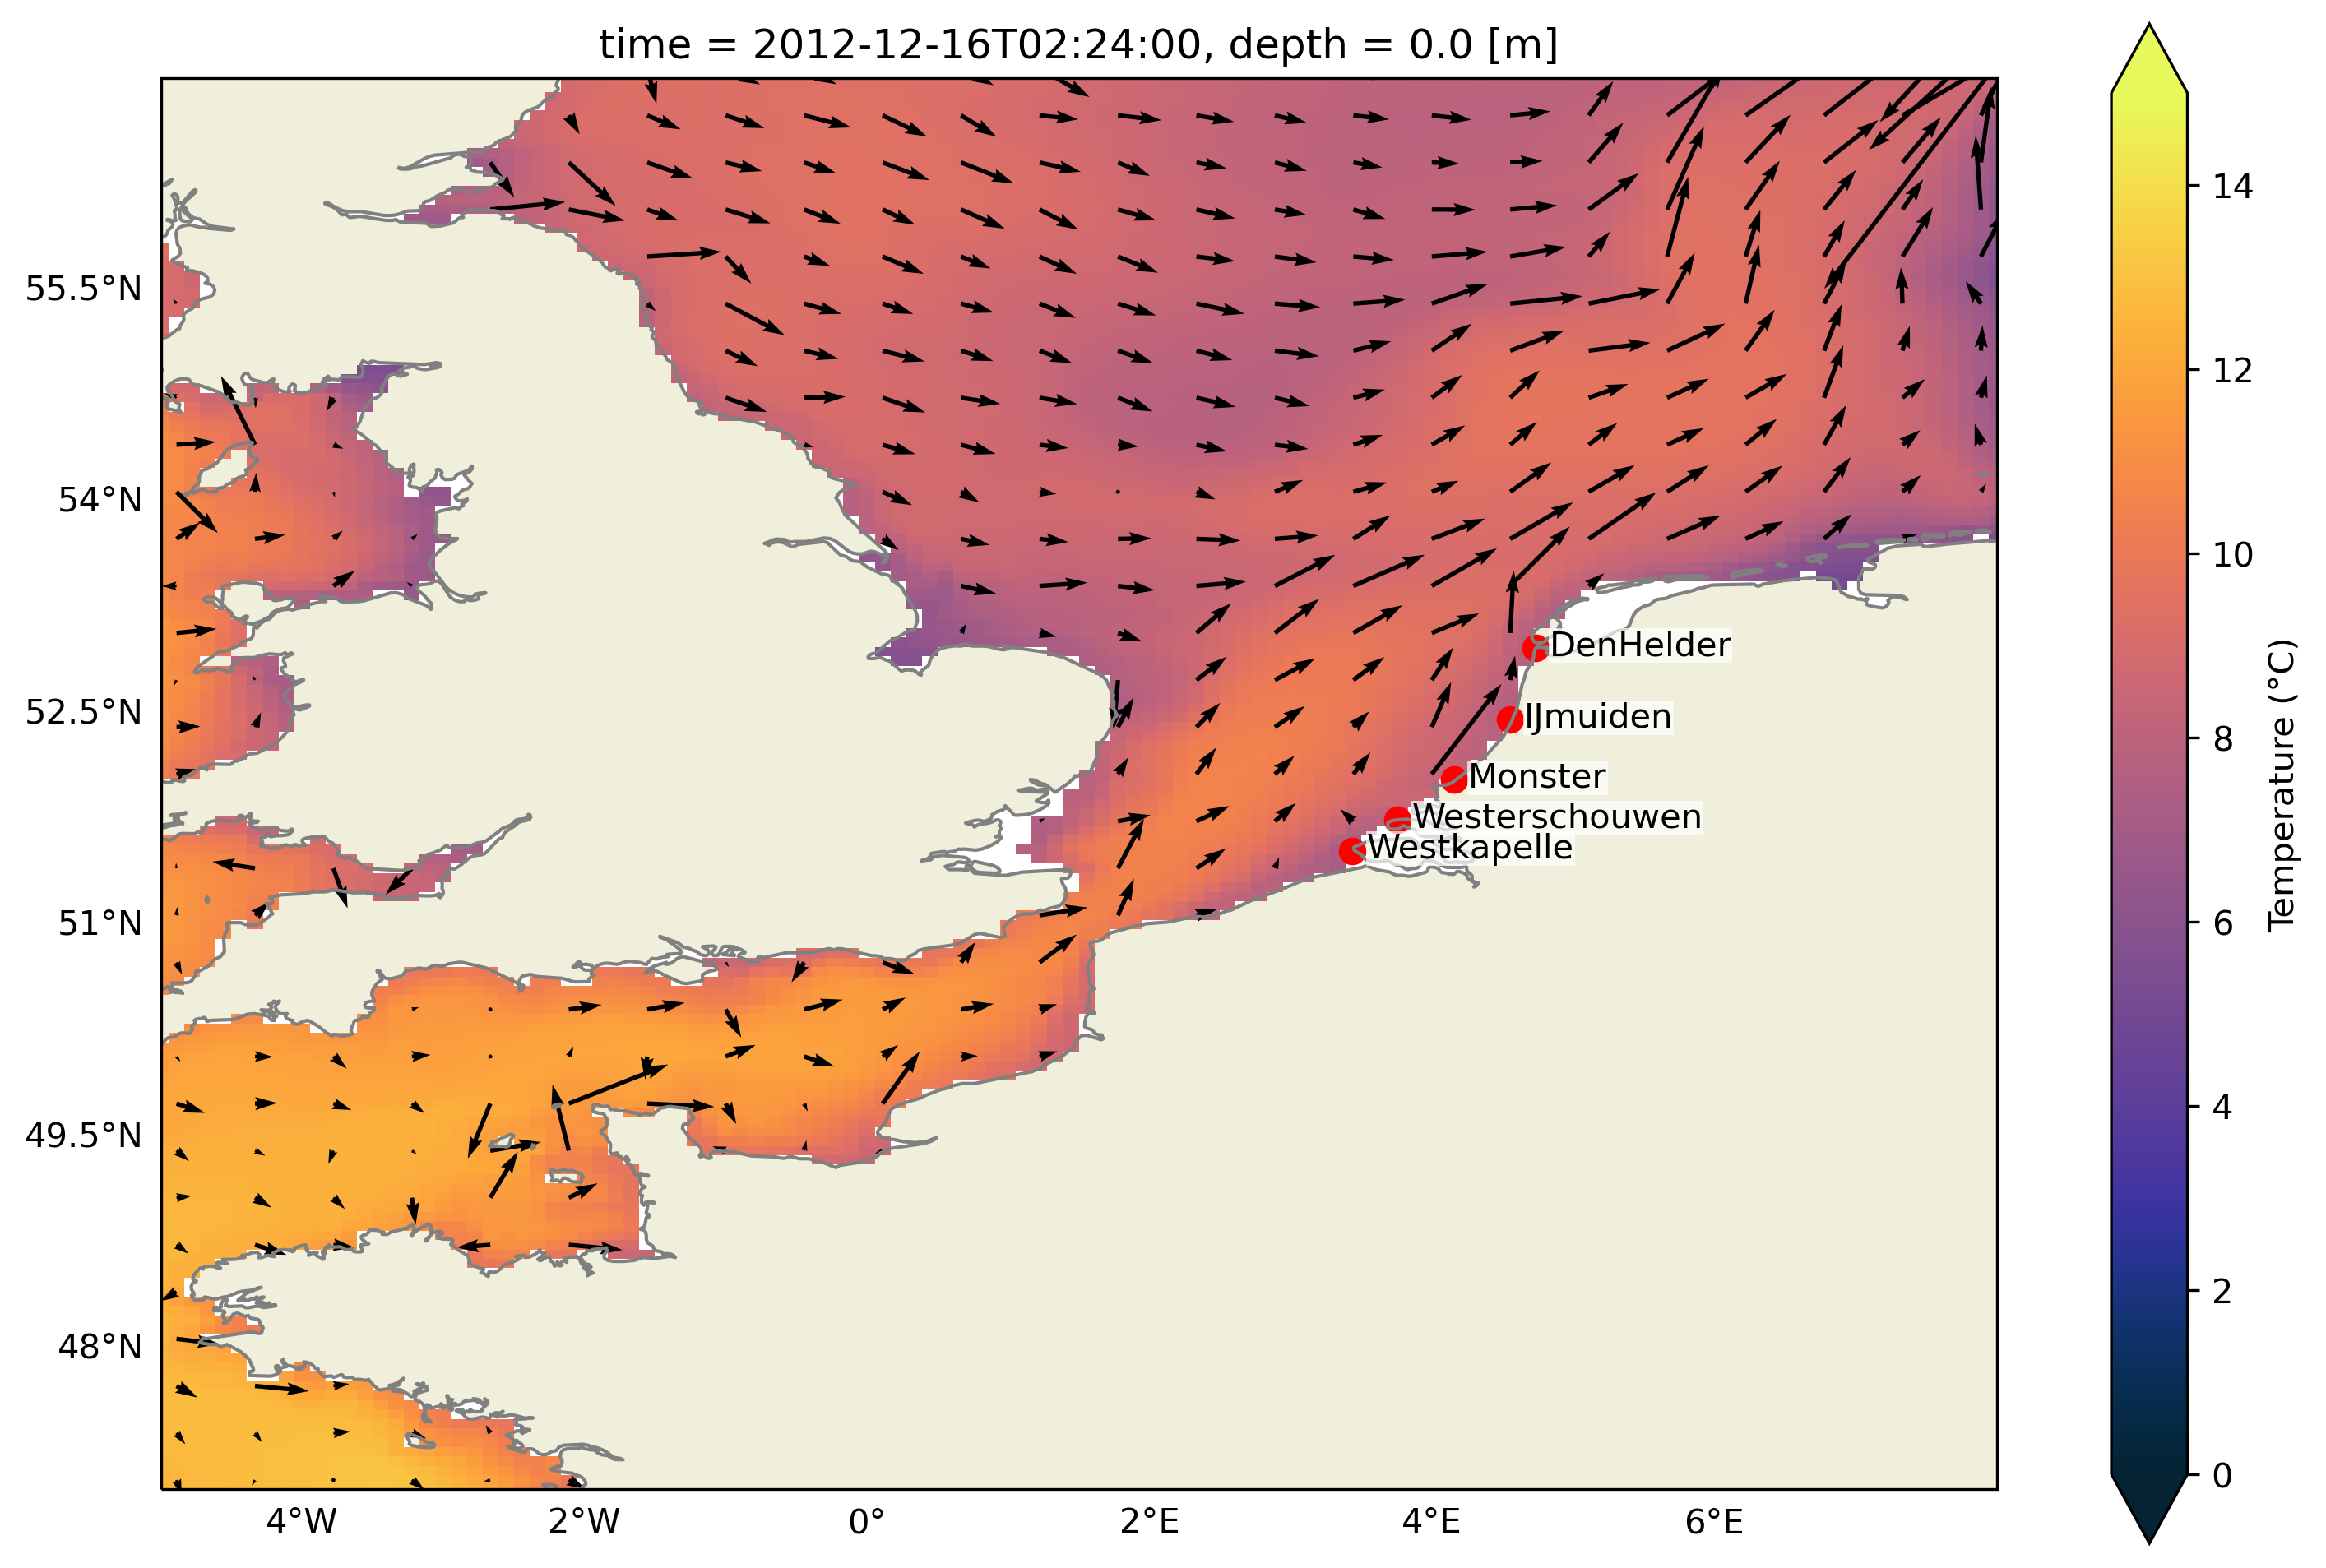

In [4]:
fig=plt.figure(figsize=(12,8),dpi=300) #generate figure  

ax = plt.subplot(111,projection=ccrs.PlateCarree())
temp_ds.thetao.plot(cmap=cm.cm.thermal,transform=ccrs.PlateCarree(),vmin=0,vmax=15,ax=ax,cbar_kwargs={'label':'Temperature (°C)'})

gl = ax.gridlines(draw_labels=True)
gl.xlines = False
gl.ylines = False
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 10, 'color': 'k'}
gl.ylabel_style = {'size': 10, 'color': 'k'}
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE, edgecolor='gray')
# ax.coastlines(resolution='50m')
ax.set_xlim(min_lon, max_lon)
ax.set_ylim(min_lat, max_lat)


sampling = 5 #don't want to plot every arrow
idx = slice(None, None, sampling)

# cu_z0=cu_ds.isel(depth=0)

ax.quiver(cu_z0.longitude[idx],cu_z0.latitude[idx],
             cu_z0.uo[idx,idx],cu_z0.vo[idx,idx],transform=ccrs.PlateCarree(), scale=2)
st_names=['IJmuiden', 'Westerschouwen', 'Monster', 'DenHelder', 'Westkapelle']

for index, st in stations.iterrows():
    strand_lon, strand_lat = st['Longitude'], st['Latitude']
    plt.scatter(strand_lon, strand_lat, c='red', marker='o', s=50)
    ax.text(strand_lon + 0.1, strand_lat - 0.05, st_names[index],
            bbox=dict(facecolor='white', alpha=0.7, pad=0.2, edgecolor='none'),
            fontsize=10)
    
plt.savefig('MeanTemp_current.jpeg')
# cu_z0.plot.quiver(x='longitude', y='latitude', u='uo', v='vo', 
#                               transform=ccrs.PlateCarree(), scale=50)     

In [5]:
# import plotly.figure_factory as ff
# import numpy as np
# x,y=np.meshgrid(cu_ds.longitude,cu_ds.latitude)
# ff.create_quiver(x, y, cu_ds.uo.isel(depth=0), cu_ds.vo.isel(depth=0))

In [6]:
cu_ds.longitude.shape, cu_ds.latitude.shape, cu_ds.uo.isel(depth=0).shape, cu_ds.vo.isel(depth=0).shape

((297,), (375,), (1, 375, 297), (1, 375, 297))

<h2>Stokes drift data</h2>

In [7]:
stokes_ds=xr.open_dataset('/storage/home/manra003/data/mean_stokesuv_December_Kemp.nc')
# stokes_ds=stokes_ds.isel(time=0)
stokes_ds

<xarray.Dataset>
Dimensions:    (longitude: 958, latitude: 1240, time: 1)
Coordinates:
  * longitude  (longitude) float32 -16.0 -15.97 -15.94 ... 12.94 12.97 13.0
  * latitude   (latitude) float32 46.0 46.01 46.03 46.04 ... 62.72 62.73 62.74
  * time       (time) datetime64[ns] 2012-12-16T00:54:00
Data variables:
    crs        int32 ...
    VSDX       (time, latitude, longitude) float32 ...
    VSDY       (time, latitude, longitude) float32 ...
Attributes:
    Conventions:          CF-1.7
    institution:          UK Met Office
    contact:              servicedesk.cmems@mercator-ocean.eu
    references:           http://marine.copernicus.eu/
    title:                3-hourly-instantaneous wave
    source:               Met Office Operational Suite, Atlantic Margin Model...
    forcing_data_source:  ECMWF; ERA-5"
    netcdf-version-id:    NETCDF4
    grid_id:              wave_nwshelf_standard_v1.1
    history:              Fri Mar  3 16:17:07 2023: ncra -v VSDX,VSDY /storag...
    NCO:                  netCDF Operators version 4.8.1 (Homepage = http://n...

In [8]:
cropped_stokes=stokes_ds.sel(latitude=slice(min_lat,max_lat), longitude=slice(min_lon,max_lon))

stokes_res = np.hypot(cropped_stokes.VSDX,cropped_stokes.VSDY).isel(time=0).to_numpy()

stokes_dir = ((270 - np.degrees(np.arctan2(cropped_stokes.VSDY, cropped_stokes.VSDX))) % 360).isel(time=0).to_numpy()
# stokes_dir = (np.arctan2(-cropped_stokes.VSDX,-cropped_stokes.VSDY)*(180/np.pi)).to_numpy()
# stokes_dir[stokes_dir<0]+=360
# Define the direction bins
direction_bins = np.arange(0,361,22.5)
# Convert the wind speed and direction data into a histogram
stokes_hist,theta,r = np.histogram2d(stokes_dir.flatten(), stokes_res.flatten(), bins=[direction_bins, 4],range=[[0, 360], [0, 0.2]])

In [9]:
u=1
v=-1
np.degrees(np.arctan2(v, u)) +360

315.0

In [10]:
((270 - np.degrees(np.arctan2(v, u))) % 360)

315.0

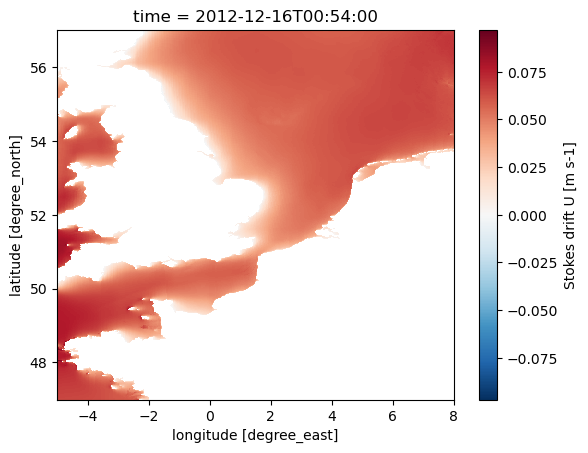

In [11]:
cropped_stokes.VSDX.plot()

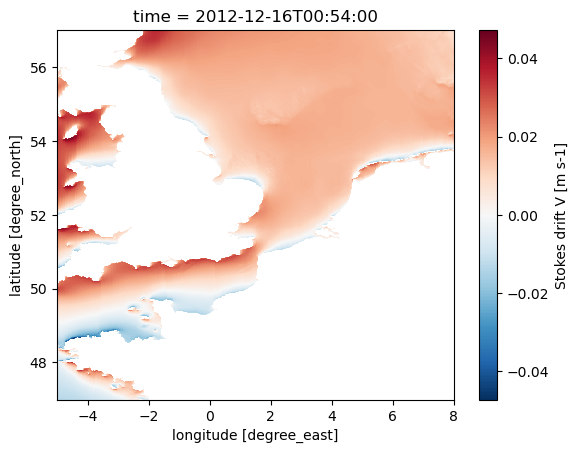

In [12]:
cropped_stokes.VSDY.plot()

In [13]:
# # Define the direction bins
# direction_bins = np.arange(0,361,22.5)
# # Convert the wind speed and direction data into a histogram
# stokes_hist,theta,r = np.histogram2d(stokes_dir.flatten(), stokes_res.flatten(), bins=[direction_bins, 4],range=[[0, 360], [0, 0.2]])

In [14]:
np.set_printoptions(suppress=True)
r

array([0.  , 0.05, 0.1 , 0.15, 0.2 ])

In [15]:
stokes_new=stokes_hist/np.sum(stokes_hist)*100
theta_a=['N','NNE','NE','ENE','E','ESE','SE','SSE','S','SSW','SW','WSW','W','WNW','NW','NNW']
speed_a=['0 - 0.05','0.05 - 0.10', '0.10 - 0.15','0.15 +']
# speed_a=np.arange(0,10,1)
mesh=np.meshgrid(speed_a,theta_a)
stokes_new

array([[ 0.01268857,  0.        ,  0.        ,  0.        ],
       [ 0.00281968,  0.        ,  0.        ,  0.        ],
       [ 0.00493444,  0.        ,  0.        ,  0.        ],
       [ 0.00493444,  0.        ,  0.        ,  0.        ],
       [ 0.0035246 ,  0.        ,  0.        ,  0.        ],
       [ 0.0035246 ,  0.        ,  0.        ,  0.        ],
       [ 0.00986888,  0.        ,  0.        ,  0.        ],
       [ 0.03242634,  0.        ,  0.        ,  0.        ],
       [ 0.34752573,  0.        ,  0.        ,  0.        ],
       [ 1.93923587,  0.02396729,  0.        ,  0.        ],
       [ 4.84844213,  5.97419992,  0.        ,  0.        ],
       [11.59523474, 65.05498379,  0.        ,  0.        ],
       [ 3.84322572,  5.0070492 ,  0.        ,  0.        ],
       [ 0.87480615,  0.14450867,  0.        ,  0.        ],
       [ 0.22416467,  0.00140984,  0.        ,  0.        ],
       [ 0.04652474,  0.        ,  0.        ,  0.        ]])

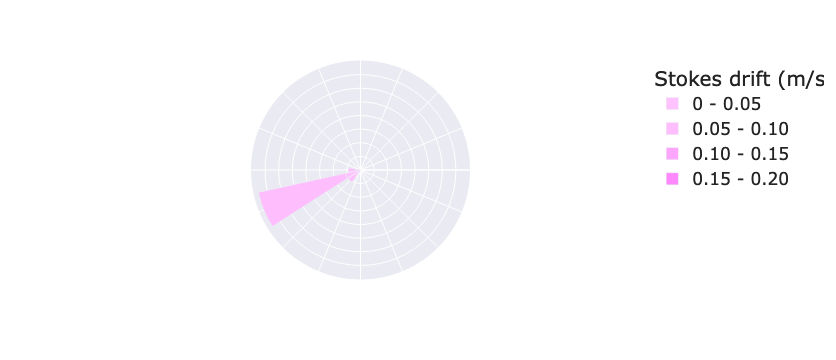

In [36]:
# stokes=pd.DataFrame({'speed': mesh[0].flatten(), 'direction': mesh[1].flatten(), 'frequency': stokes_new.flatten()})

# fig = px.bar_polar(stokes, r="frequency", theta="direction",
#                    color="speed",template="seaborn",
#                    color_discrete_sequence= pt.colors.sequential.Plotly3_r,
#                    labels={"speed": "Stokes drift (m/s)"})
# fig.update_layout(
#     font_size=15,
#     legend_font_size=17,
#     polar_radialaxis_ticksuffix='%',
#     paper_bgcolor= 'rgba(0, 0, 0, 0)',
#     polar_radialaxis={'showticklabels': False},
#     # polar_angularaxis={'visible': False, 'showticklabels': False}
#     polar_angularaxis={'showticklabels': False}
# )
# fig.show()
# # fig.write_image('stokes_dec.png', scale=4)

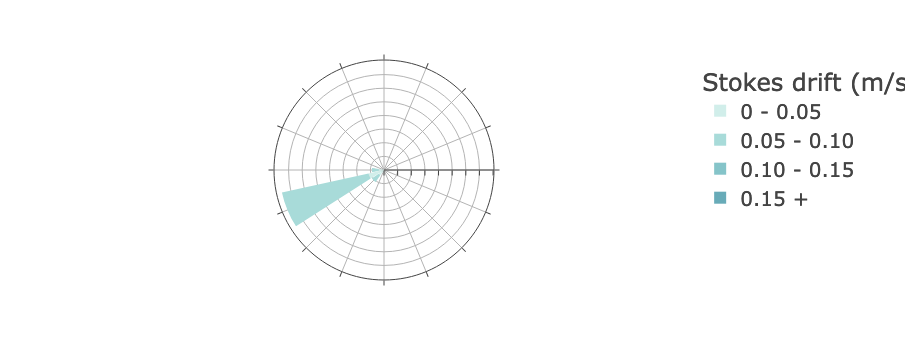

In [16]:
stokes=pd.DataFrame({'speed': mesh[0].flatten(), 'direction': mesh[1].flatten(), 'frequency': stokes_new.flatten()})

fig = px.bar_polar(stokes, r="frequency", theta="direction",
                   color="speed",template="none",
                   # color_continuous_scale= pt.colors.sequential.Blues,
                   color_discrete_sequence= pt.colors.sequential.Teal,
                   labels={"speed": "Stokes drift (m/s)"})
fig.update_layout(
    font_size=15,
    legend_font_size=20,
    polar_radialaxis_ticksuffix='%',
    plot_bgcolor = 'rgba(0, 0, 0, 0)',
    paper_bgcolor = 'rgba(0, 0, 0, 0)',
    polar_radialaxis={'showticklabels': False},
    # polar_angularaxis={'visible': False, 'showticklabels': False}
    polar_angularaxis={'showticklabels': False}
)
fig.show()
fig.write_image('stokes_dec.png', scale=4)


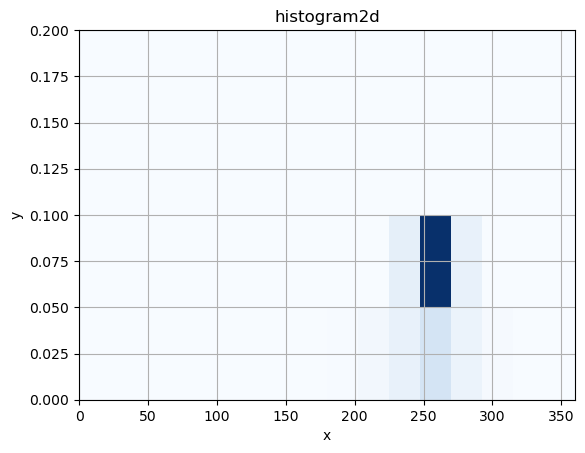

In [17]:
fig, (ax1) = plt.subplots(ncols=1)

ax1.pcolormesh(theta,r, stokes_hist.T, cmap='Blues')

# ax1.plot(x, 2*np.log(x), 'k-')

# ax1.set_xlim(x.min(), x.max())

# ax1.set_ylim(y.min(), y.max())

ax1.set_xlabel('x')

ax1.set_ylabel('y')

ax1.set_title('histogram2d')

ax1.grid()

In [18]:
# # Create the wind rose plot
# fig, ax = plt.subplots(subplot_kw=dict(projection='polar'))
# ax.set_theta_direction(-1)
# ax.set_theta_zero_location('N')
# ax.set_xticks(direction_bins[:-1] * np.pi / 180.0)
# # ax.set_xticklabels(['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'])
# ax.set_yticks([1, 3, 5, 7])
# ax.set_yticklabels(['0.25', '0.5', '0.75', '1.0'])
# ax.pcolormesh(np.radians(direction_bins), [0, 1, 3, 5, 7], stokes_hist.T, cmap='Blues')
# plt.show()

<h2>Wind data</h2>

In [21]:
data_path = '/nethome/manra003/analysis/KempRidley/ERA5_EUWsubset/'
wind_files= sorted(glob(data_path + 'reanalysis-era5-single-level_wind10m_200712*.nc')
                     +glob(data_path + 'reanalysis-era5-single-level_wind10m_200812*.nc')
                     +glob(data_path + 'reanalysis-era5-single-level_wind10m_201112*.nc')
                     +glob(data_path + 'reanalysis-era5-single-level_wind10m_201412*.nc')
                     +glob(data_path + 'reanalysis-era5-single-level_wind10m_202112*.nc'))

In [22]:
wind_ds = xr.open_mfdataset(wind_files).mean('time')
wind_ds

<xarray.Dataset>
Dimensions:    (longitude: 121, latitude: 101)
Coordinates:
  * longitude  (longitude) float32 -20.0 -19.75 -19.5 -19.25 ... 9.5 9.75 10.0
  * latitude   (latitude) float32 65.0 64.75 64.5 64.25 ... 40.5 40.25 40.0
Data variables:
    u10        (latitude, longitude) float32 dask.array<chunksize=(101, 121), meta=np.ndarray>
    v10        (latitude, longitude) float32 dask.array<chunksize=(101, 121), meta=np.ndarray>

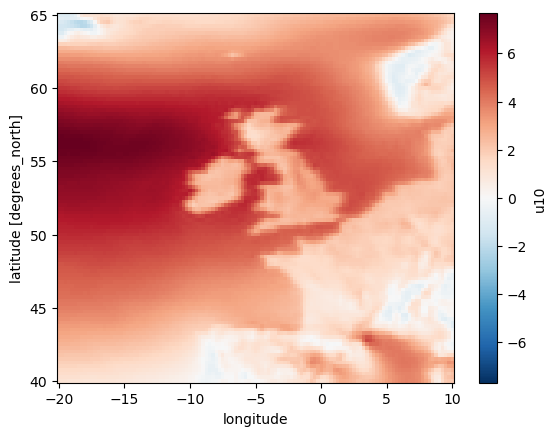

In [23]:
wind_ds.u10.plot()

In [32]:
cropped_wind = wind_ds.sel(latitude=slice(max_lat, min_lat), longitude=slice(min_lon,max_lon))
wind_res = np.hypot(cropped_wind.u10,cropped_wind.v10).to_numpy()
print(np.min(wind_res), np.max(wind_res))

wind_dir  = ((270 - np.degrees(np.arctan2(cropped_wind.v10, cropped_wind.u10))) % 360).to_numpy()
# Convert the wind speed and direction data into a histogram

wind_hist, w_theta, w_r = np.histogram2d(wind_dir.flatten(), wind_res.flatten(), bins=[direction_bins, 4],range=[[0, 360], [0, 6.0]])

0.5867033 6.0779


In [33]:
w_r

array([0. , 1.5, 3. , 4.5, 6. ])

In [34]:
wind_new = wind_hist/np.sum(wind_hist)*100
theta_a = ['N','NNE','NE','ENE','E','ESE','SE','SSE','S','SSW','SW','WSW','W','WNW','NW','NNW']
speed_a = ['0 - 1.5','1.5 - 3.0', '3.0 - 4.5','4.5 - 6.0']
# speed_a=np.arange(0,10,1)
mesh = np.meshgrid(speed_a,theta_a)
wind_new

array([[ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.23062731,  0.        ,  0.        ],
       [ 0.27675277,  1.61439114,  0.        ,  0.        ],
       [ 0.69188192, 24.1697417 ,  3.96678967,  1.06088561],
       [ 1.84501845, 15.12915129, 18.17343173, 23.66236162],
       [ 0.18450185,  1.19926199,  4.38191882,  2.67527675],
       [ 0.        ,  0.09225092,  0.64575646,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ]])

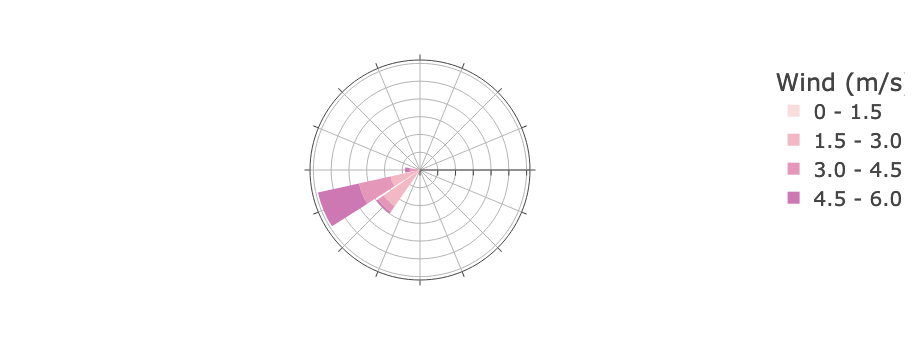

In [35]:
winds=pd.DataFrame({'speed': mesh[0].flatten(), 'direction': mesh[1].flatten(), 'frequency': wind_new.flatten()})

fig = px.bar_polar(winds, r="frequency", theta="direction",
                   color="speed",template="none",
                   # color_continuous_scale= pt.colors.sequential.Blues,
                   color_discrete_sequence= pt.colors.sequential.Purpor,
                   labels={"speed": "Wind (m/s)"})
fig.update_layout(
    font_size=15,
    legend_font_size=20,
    polar_radialaxis_ticksuffix='%',
    plot_bgcolor = 'rgba(0, 0, 0, 0)',
    paper_bgcolor = 'rgba(0, 0, 0, 0)',
    polar_radialaxis={'showticklabels': False},
    # polar_angularaxis={'visible': False, 'showticklabels': False}
    polar_angularaxis={'showticklabels': False}
)
fig.show()
fig.write_image('winds_dec.png', scale=4)


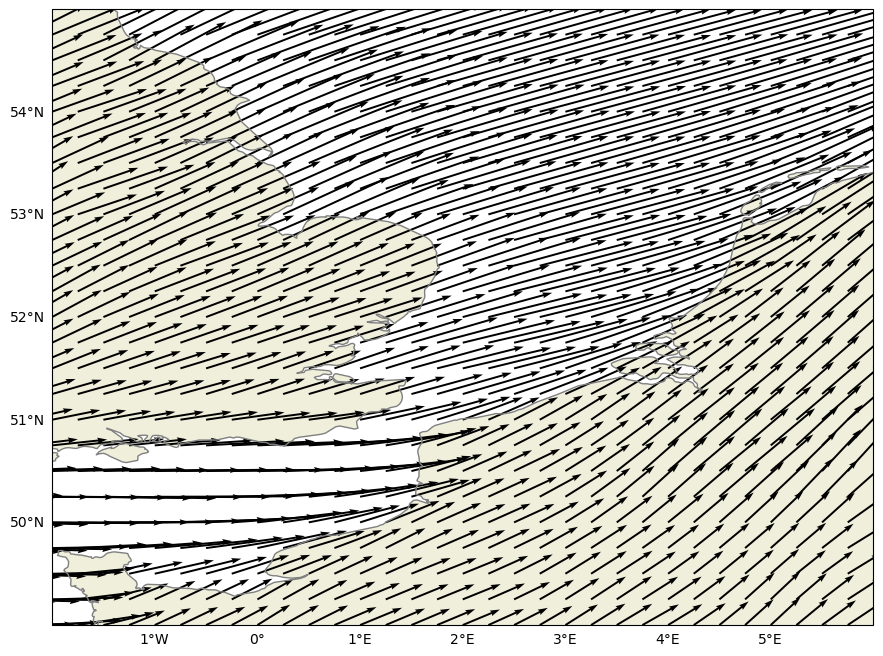

In [13]:
fig=plt.figure(figsize=(12,8)) #generate figure  

ax = plt.subplot(111,projection=ccrs.PlateCarree())
# wind_ds.thetao.plot(cmap=cm.cm.thermal,transform=ccrs.PlateCarree(),vmin=0,vmax=15,ax=ax,cbar_kwargs={'label':'Temperature [C]'})

gl = ax.gridlines(draw_labels=True)
gl.xlines = False
gl.ylines = False
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 10, 'color': 'k'}
gl.ylabel_style = {'size': 10, 'color': 'k'}
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE, edgecolor='gray')
# ax.coastlines(resolution='50m')
ax.set_xlim()
ax.set_xlim(-2,6)
ax.set_ylim(49,55)
sampling = 1 #don't want to plot every arrow
idx = slice(None, None, sampling)

# cu_z0=cu_ds.isel(depth=0)

ax.quiver(wind_ds.longitude[idx],wind_ds.latitude[idx],
             wind_ds.u10[idx,idx],wind_ds.v10[idx,idx],transform=ccrs.PlateCarree(), scale=40)


# wind_ds.plot.quiver(x='longitude', y='latitude', u='u10', v='v10', 
#                               transform=ccrs.PlateCarree(), scale=50)     